# Internal Tide (only): advection & mixing sensitivity

The difference between UP3 (SPLINES) and UP5 is very small compared to the difference between resolution (1km vs 2km, and doubling of number of vertical levels).


In [1]:
from glob import glob
import itertools

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import xarray as xr

import crocosi.postp as pp
import crocosi.gridop as op
import crocosi.plot as cplt
import crocosi.vmodes as vmd

In [2]:
from dask.distributed import Client, LocalCluster

if False:
    cluster = LocalCluster()
else:
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=2)
#
client = Client(cluster)
client

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import parse_bytes


Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: http://10.148.0.220:8787/status,
Dashboard: http://10.148.0.220:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.220:46291,Workers: 0
Dashboard: http://10.148.0.220:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load data

In [3]:
# paths
#root_path = '/home/datawork-lops-osi/equinox/itbalt/'
root_path = '/home1/scratch/slgentil/' 

A = ["UP3", "UP5"]
Re = [2,1]

_ls = ["-", "-"]
_colors = cplt.get_cmap_colors(len(A))
_lw = [3,1]

runs, lstyles = {}, {}
for i, a in enumerate(A):
    for j, r in enumerate(Re):
        if a=="UP3":
            _a = ""
        else:
            _a = a+"_"
        key = "a{}_r{}".format(a,r)
        runs[key] = "fsturb_{}h100_{}km_0a50j".format(_a,r)
        lstyles[key] = dict(color=_colors[i], ls=_ls[j], lw=_lw[j])

In [4]:
runs

{'aUP3_r2': 'fsturb_h100_2km_0a50j',
 'aUP3_r1': 'fsturb_h100_1km_0a50j',
 'aUP5_r2': 'fsturb_UP5_h100_2km_0a50j',
 'aUP5_r1': 'fsturb_UP5_h100_1km_0a50j'}

In [5]:
def load_run(run, key):    
    r = pp.Run(root_path+run, outputs=["sec"], grid_periodicity=True, verbose=0)
    ds = r['sec'].assign_coords(time=r['sec'].time_counter)
    
    ds = ds.isel(x_rho=0)
    for v in ds:
        ds[v] = process_dim(ds[v])
    ds = ds.rename({v: v.replace("_yz", "") for v in ds})
    ds = ds.drop(["x_rho", "x_rhoy", "x_uy", "x_vy", "y_rhoy", "y_uy", "y_vy"])
    
    # rechunk along time for larger runs
    y = r["sec"].y_rhoy
    resolution = int(float(y[1]-y[0])/1e3)
    if resolution<=2:
        ds = ds.chunk({"time": 10}) # 2km
    if resolution<=1:
        ds = ds.chunk({"y_rho": 1000, "y_v": 1000})
    
    r["sec"] = ds
    r.resolution = resolution
    r.itide_h = r.params_output["itide_h"]
    #r.label = 'H_itide={}m dx={}km'.format(r.itide_h, r.resolution)
    r.a = key.split("_")[0].replace("a","")
    r.label = 'adv={}, H_itide={}m, dx={}km'.format(r.a, r.itide_h, r.resolution)
    
    return r

# specific to 2D run ...
def process_dim(da):
    rdict = {}
    for d, d_new in {"y_rhoy": "y_rho", "y_uy": "y_rho", "y_vy": "y_v"}.items(): 
        if d in da.dims:
            rdict[d] = d_new
    return da.rename(rdict)

R = {key: load_run(run, key) for key, run in runs.items()}

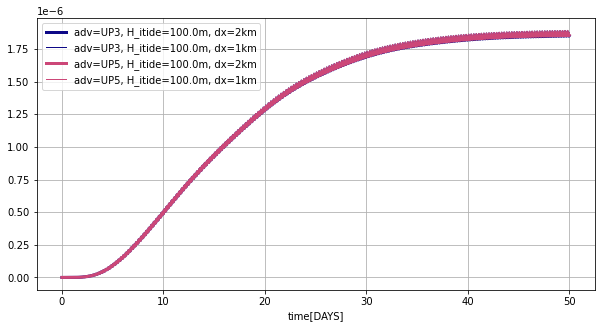

In [6]:
# quickly look at energies
fig, ax = plt.subplots(figsize=(10,5))

for key, r in R.items():
    r.stats['KINETIC_ENRG'].plot(ax=ax, label=r.label, **lstyles[key])
    #r.stats['BTKIN_ENRG'].plot(ax=ax, lw=1., color=_c, ls=_ls, label=r.label+' bt')
    # ax.get_lines()[-1].get_color()
ax.legend()
ax.grid()

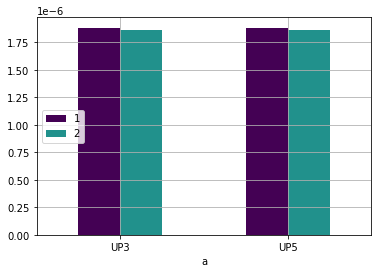

In [8]:
index = pd.MultiIndex.from_tuples([(r.a, r.resolution) for key, r in R.items()], 
                                  names=["a", "r"],
                                 )
tmax = max(r.stats['KINETIC_ENRG'].index)
df = pd.DataFrame([r.stats.loc[tmax-1:].mean() for key, r in R.items()]
                  , index=index
                 )
fig, ax = plt.subplots(1,1)
(df["KINETIC_ENRG"].unstack()
 .plot.bar(ax=ax, rot=0, 
           color=cplt.get_cmap_colors(len(Re), cmap="viridis"))
)
ax.grid()
ax.legend(loc=6)

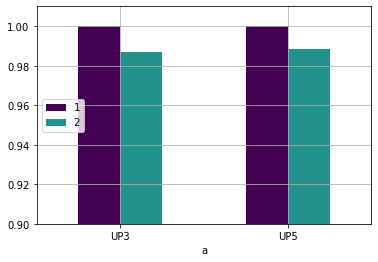

In [9]:
ds = df.to_xarray()
df_norm = (ds["KINETIC_ENRG"] / ds["KINETIC_ENRG"].sel(r=1)).to_dataframe()

fig, ax = plt.subplots(1,1)
(df_norm["KINETIC_ENRG"].unstack()
 .plot.bar(ax=ax, rot=0, 
           color=cplt.get_cmap_colors(len(Re), cmap="viridis"))
)
ax.grid()
ax.set_ylim(.9,1.01)
ax.legend(loc=6)

---

## plot sections

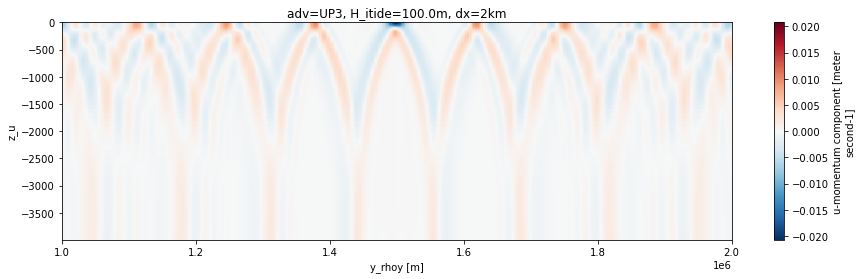

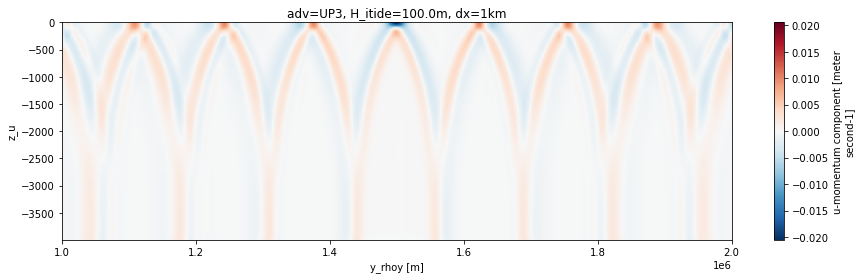

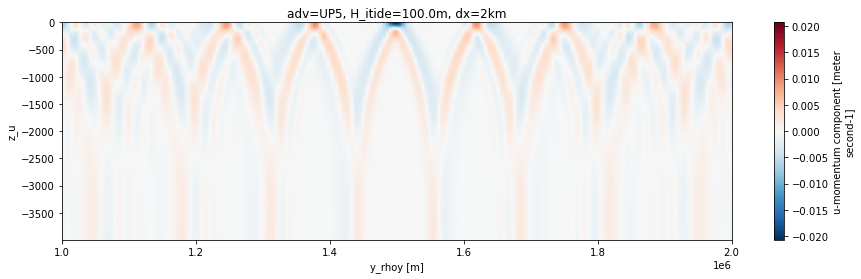

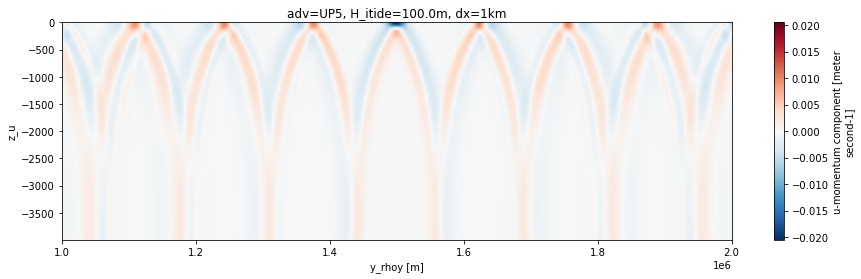

In [10]:
def plot_section(r):
    
    ds = r["sec"]
    z_u = r.get_z(zeta=ds.ssh, h=ds.ssh*0+r["depth"])
    ds = ds.assign_coords(z_u = z_u)

    #time_slice = [5, 10, 50]
    time_slice = 50

    (ds.u
     .sel(time=time_slice)
     .plot(x='y_rho', y='z_u', 
           xlim=(1000*1e3,2000*1e3),
           #vmax=5*1e-4,
           figsize=(15,4),
           #figsize=(15,8),
           #col='time', col_wrap=1,
          ),
    )
    plt.title(r.label)
    
for _, r in R.items():
    plot_section(r)

---

## process data

1. compute modes
2. project velocity

In [11]:
def process_run(r):
    
    ds = r["sec"]
    
    tmax = ds.time.max()
    ds = ds.sel(time=slice(tmax-5, tmax))

    # time dependent vertical grid
    h = r["grid"]["h"].isel(x_rho=0)
    ds = ds.assign_coords(h=h)
    ds = ds.assign_coords(z_r = r.get_z(zeta=ds["ssh"], h=h, vgrid="r"),
                          z_w = r.get_z(zeta=ds["ssh"], h=h, vgrid="w"),
                         )
    r["sec"] = ds.persist()
    
    # spatial and temporal mean stratification
    dsm = (ds
          .mean(dim=["time","y_rho"])
          .persist()
         )

    h = r["grid"]["h"].isel(x_rho=0, y_rho=0)
    del h["y_rho"]

    zm_r = r.get_z(zeta=dsm.ssh, h=h)
    zm_w = r.get_z(zeta=dsm.ssh, h=h, vgrid='w')

    # interpolate first and the compute modes
    rho = ds["T"].rename('rho')
    rho_i = op.interp2z(zm_r, ds.z_r, rho) # time dependent to mean vertical grid
    rho_m = rho_i.mean(["y_rho","time"])

    # compute pressure anomaly
    p = get_p(r['xgrid'],
              rho_i - rho_m,
              zm_w,
              ds["ssh"],
              r.params_input["rho0"],
             )
    
    # vertical modes
    N2 = r.get_N2(rho_m, zm_r)
    r.vm = vmd.Vmodes(r['xgrid'], zm_r, zm_w, N2, 10, persist=True)
    
    # project velocity and pressure
    un = r.vm.project(ds["u"], "p", z=ds.z_r)
    v = r.x2rho(ds["v"])
    vn = r.vm.project(v, "p", z=ds.z_r)
    pn = r.vm.project(p, "p", z=zm_r)
    
    r.vm.dsp = xr.merge([highp_48(un).rename("un"), 
                         highp_48(vn).rename("vn"), 
                         highp_48(pn).rename("pn"),
                        ]
                       ).persist()
    
    # compute the flux of energy over the last days
    u = op.interp2z(zm_r, ds.z_r, ds["u"]) 
    v = op.interp2z(zm_r, ds.z_r, v)
    u_prime = highp_48(u).rename("u")
    v_prime = highp_48(v).rename("v")
    p_prime = highp_48(p).rename("p")
    
    r.Fy = ((v_prime*p_prime)
            .mean("time")
            .rename("Fy")
            .assign_coords(z_r=zm_r)
            .persist()
           )
    r.UVP = (xr.merge([u_prime, v_prime, p_prime])
             .std("time")
             .assign_coords(z_r=zm_r)
             .persist()
            )
    
def get_p(grid, rho, zw, ssh, rho0):
    g = 9.81
    dz = grid.diff(zw, "s") # >0
    p = -grid.cumsum(rho*dz, "s", to="outer", boundary="extend") # integrate from the bottom up
    #p = grid.cumint(rho, "s", to="outer", boundary="extend")
    p = p - p.sel(s_w=0, method="nearest") + ssh*rho0
    p = grid.interp(p, "s") # interpolate back to rho grid
    return g*p.rename("p")
    
def highp_48(da):
    da_low = da.rolling(time=24, center=True).mean().dropna("time")
    tmax = r["sec"].time.max()
    return (da - da_low).sel(time=slice(tmax-2, tmax))
    
for _, r in R.items():
    process_run(r)

### inspect energy distribution amongst vertical modes

In [12]:
# utils
def find_r(R, res, a, fun):
    for _, r in R.items():
        if r.resolution==res and r.a==a:
            return fun(r)

#colors = {d:c for d, c in zip(itide_hs, cplt.get_cmap_colors(len(itide_hs)))}
#ls = {1: "-",2:"--", 4: "-."}
#labels = ['H_itide={}m dx={}km'.format(r.itide_h, r.resolution) for r in R]        
        
resolutions = list(set([r.resolution for _, r in R.items()]))
advs = sorted(set([r.a for _,r in R.items()]))

colors_res = {d:c for d, c in zip(resolutions, cplt.get_cmap_colors(len(resolutions), "viridis"))}

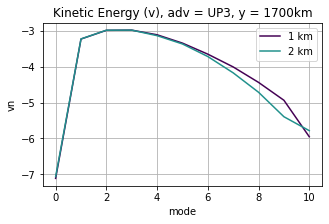

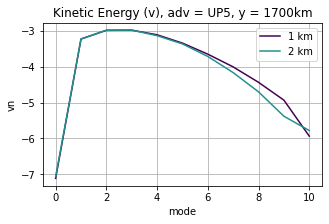

In [13]:
y=1700e3
get_diag = lambda r: (r.vm.dsp["vn"]
                      .sel(y_rho=y, method="nearest")
                      .std("time")
                     )

for a in advs:
    fig, ax = plt.subplots(1, 1, figsize=(5,3))
    for res in resolutions:
        E = find_r(R, res, a, get_diag)
        np.log10(E).plot(ax=ax, x="mode", color=colors_res[res], label="{} km".format(res))
    ax.legend()
    ax.grid()
    ax.set_title("Kinetic Energy (v), adv = {}, y = {}km".format(a, int(y/1e3)))

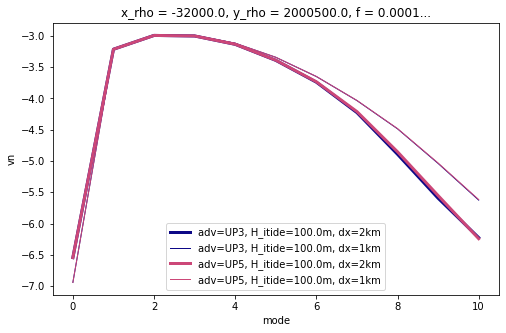

In [14]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
for key, r in R.items():
        
    y = 2000e3
    toplt = (r.vm.dsp["vn"]
             .sel(y_rho=y, method="nearest")
             .std("time")
            )
    toplt = np.log10(toplt)
    toplt.plot(ax=ax, label=r.label, **lstyles[key])

ax.legend()

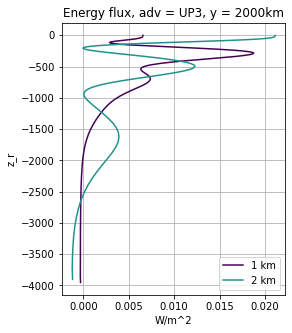

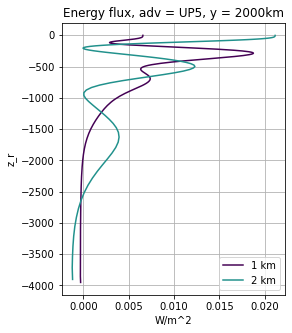

In [15]:
get_diag = lambda r: r.Fy.sel(y_rho=y, method="nearest")

for a in advs:
    fig, ax = plt.subplots(1, 1, figsize=(4,5))
    for res in resolutions:
        Fy = find_r(R, res, a, get_diag)
        Fy.plot(ax=ax, y="z_r", color=colors_res[res], label="{} km".format(res))
    ax.legend()
    ax.grid()
    ax.set_title("Energy flux, adv = {}, y = {}km".format(a, int(y/1e3)))
    ax.set_xlabel("W/m^2")

In [16]:
R

{'aUP3_r2': Run: /home1/scratch/slgentil/fsturb_h100_2km_0a50j
   output keys: grid / sec,
 'aUP3_r1': Run: /home1/scratch/slgentil/fsturb_h100_1km_0a50j
   output keys: grid / sec,
 'aUP5_r2': Run: /home1/scratch/slgentil/fsturb_UP5_h100_2km_0a50j
   output keys: grid / sec,
 'aUP5_r1': Run: /home1/scratch/slgentil/fsturb_UP5_h100_1km_0a50j
   output keys: grid / sec}

Text(0.5, 1.0, 'Fy')

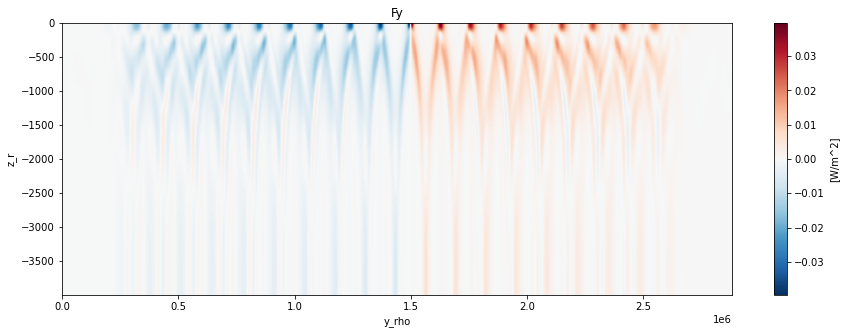

In [17]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
toplt = R["aUP5_r1"].Fy
toplt.plot(ax=ax, x="y_rho", y="z_r", cbar_kwargs={"label": "[W/m^2]"})
ax.set_title("Fy")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


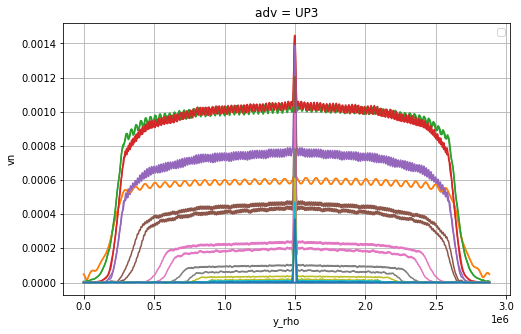

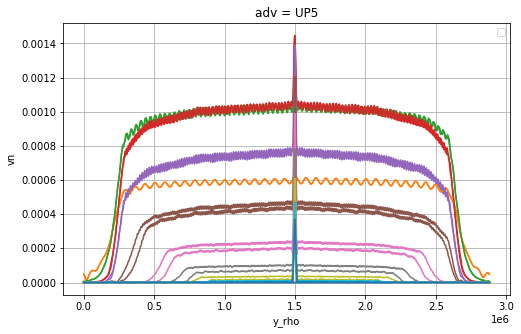

In [18]:
mode_max = 6

for a in advs:
    
    fig, ax = plt.subplots(1,1, figsize=(8,5))
    for key, r in R.items():
        if r.a==a:
            _ls = lstyles[key]["ls"]
            _ds = r.vm.dsp["vn"].std("time")
            for m in _ds.mode:
                _p = _ds.sel(mode=m)
                label = ""
                if r.resolution==4:
                    label = "mode {}".format(int(m))
                _p.plot(ax=ax, ls=_ls, hue="mode", add_legend=False, label=label)
            plt.gca().set_prop_cycle(None)
    ax.set_title("adv = {}".format(a))
    ax.grid()
    ax.legend()

---

In [ ]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
